In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# a scoring metric that Kaggle competitions have used in the past
# lower score is better, penalizes you for high probability wrong guesses
def brier_score(pred_prob, ytrue):
  return np.mean((pred_prob - ytrue)**2)

In [4]:
# Read in data and clean it up for testing (i.e. use season averages)
DATA_PATH = 'drive/MyDrive/march_madness/2024/' # connected to my Google Drive

# only tournament games since 2003 for men's and 2010 for women's
df = pd.read_csv(DATA_PATH + 'final_data_2003-2023.csv')

print(df.shape)
df.head()

(4284, 18)


,Season,TeamIDA,TeamIDB,Weights,SeedA,SeedB,WinRatio14A,OffEffA,DefEffA,EFTA,WinRatioA,WinRatio14B,OffEffB,DefEffB,EFTB,WinRatioB,ScoreDiff,WinA
0,2003,1421,1411,2,16,16,1.000000,105.315164,115.456256,0.489800,0.448276,0.833333,107.187241,105.071425,0.503036,0.600000,8,1
1,2003,1112,1436,2,1,16,0.666667,115.232944,95.117513,0.517632,0.892857,1.000000,106.911164,99.247639,0.494732,0.655172,29,1
2,2003,1113,1272,2,10,7,0.500000,113.782349,103.406731,0.517334,0.620690,0.750000,109.889666,97.004974,0.498337,0.793103,13,1
3,2003,1141,1166,2,11,6,1.000000,114.122499,105.421379,0.572835,0.793103,1.000000,118.566346,96.739284,0.567455,0.878788,6,1
4,2003,1143,1301,2,8,9,0.500000,109.611481,102.725168,0.524098,0.724138,0.500000,111.669631,105.001178,0.534189,0.600000,2,1


In [5]:
# Set up X and Y
to_drop = ['Season', 'TeamIDB', 'ScoreDiff', 'WinA']
X = df.drop(to_drop, axis=1) # features
Y = df['WinA'] # target

# Split into training and testing
#    Important to test your model on unseen data, to avoid overfitting and
#    to ensure it is generalizable
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Use standard scaler on features
#    Important for some ML models to ensure all the features are similarly
#    scaled, so model doesn't overprioritize data simply because of magnitudes
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
model = LogisticRegression()
model.fit(X_train_scaled, Y_train)
print('Training accuracy: {:.4f}'.format(model.score(X_train_scaled, Y_train)))
print('Testing accuracy: {:.4f}'.format(model.score(X_test_scaled, Y_test)))

train_prob = model.predict_proba(X_train_scaled)
test_prob = model.predict_proba(X_test_scaled)

print('Training Brier Score: {:.4f}'.format(brier_score(train_prob[:,1], Y_train)))
print('Testing Brier Score: {:.4f}'.format(brier_score(test_prob[:,1], Y_test)))

Training accuracy: 0.7402
Testing accuracy: 0.7325
Training Brier Score: 0.1711
Testing Brier Score: 0.1770


### Random forest

https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles

In [8]:
from sklearn.ensemble import RandomForestClassifier

100%|██████████| 99/99 [01:55<00:00,  1.17s/it]


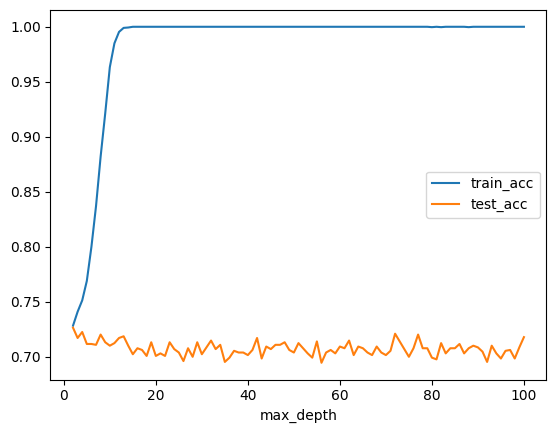

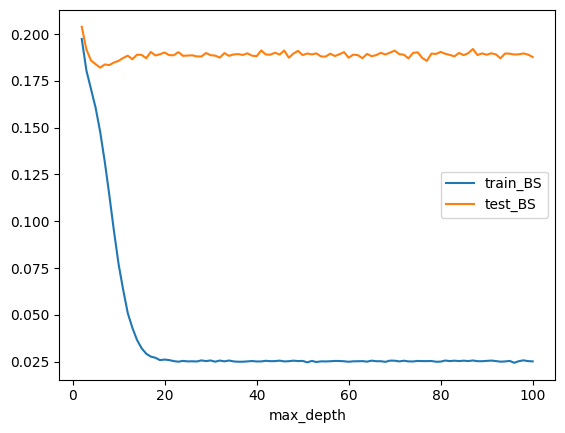

In [9]:
# max_depth is one of the important hyperparameters for random forest
#     Instead of doing a full cross-validation to determine the best
#     hyperparameters, I do a simple scan across max_depth
max_depth_min = 2
max_depth_max = 100

# initialize some lists to store data
max_depth_list = []
train_acc = []
test_acc = []
train_BS = []
test_BS = []

for m in tqdm(np.arange(max_depth_min, max_depth_max+1)):
  max_depth_list.append(m)
  model = RandomForestClassifier(max_depth=m)
  model.fit(X_train_scaled, Y_train)
  train_acc.append(model.score(X_train_scaled, Y_train))
  test_acc.append(model.score(X_test_scaled, Y_test))

  train_prob = model.predict_proba(X_train_scaled)
  test_prob = model.predict_proba(X_test_scaled)

  train_BS.append(brier_score(train_prob[:,1], Y_train))
  test_BS.append(brier_score(test_prob[:,1], Y_test))

# convert to pandas
errors = pd.DataFrame()
errors['max_depth'] = max_depth_list
errors['train_acc'] = train_acc
errors['test_acc'] = test_acc
errors['train_BS'] = train_BS
errors['test_BS'] = test_BS

errors.plot(x='max_depth', y=['train_acc', 'test_acc'])
errors.plot(x='max_depth', y=['train_BS', 'test_BS'])

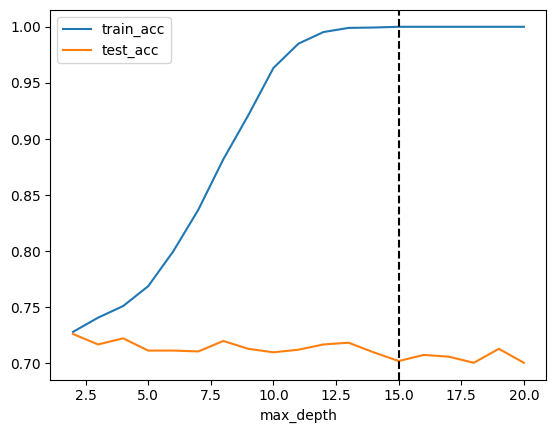

In [10]:
errors[errors['max_depth'] <= 20].plot(x='max_depth', y=['train_acc', 'test_acc'])
plt.axvline(15, ls='dashed', c='k') # pick a point when the accuracy is not changing

In [11]:
errors[errors['max_depth'] == 15]

,max_depth,train_acc,test_acc,train_BS,test_BS
13,15,1.0,0.702177,0.032161,0.188866


### Gradient boosting tree

https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosted-trees

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [13]:
# manually choosing some of the important parameters to test accuracy
params = {
    'n_estimators' : 100,
    'max_depth' : 2,
    'learning_rate' : 0.2,
    'subsample' : 0.5,
    'min_samples_leaf' : 100,
    'max_leaf_nodes' : 1000
    }

gbc = GradientBoostingClassifier(**params, verbose=1)
gbc.fit(X_train_scaled, Y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2968           0.0902            0.94s
         2           1.2264           0.0579            0.81s
         3           1.1825           0.0410            0.78s
         4           1.1729           0.0253            0.72s
         5           1.1101           0.0216            0.67s
         6           1.1133           0.0128            0.63s
         7           1.0975           0.0168            0.60s
         8           1.0907           0.0114            0.57s
         9           1.0873           0.0059            0.55s
        10           1.0649           0.0095            0.53s
        20           1.0378           0.0005            0.41s
        30           1.0316           0.0001            0.34s
        40           0.9964          -0.0015            0.28s
        50           0.9644          -0.0004            0.23s
        60           0.9424          -0.0016            0.18s
       

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, max_leaf_nodes=1000,
                           min_samples_leaf=100, subsample=0.5, verbose=1)

In [14]:
print('Training accuracy: {:.4f}'.format(gbc.score(X_train_scaled, Y_train)))
print('Testing accuracy: {:.4f}'.format(gbc.score(X_test_scaled, Y_test)))

train_prob = gbc.predict_proba(X_train_scaled)
test_prob = gbc.predict_proba(X_test_scaled)

print('Training Brier Score: {:.4f}'.format(brier_score(train_prob[:,1], Y_train)))
print('Testing Brier Score: {:.4f}'.format(brier_score(test_prob[:,1], Y_test)))

Training accuracy: 0.7718
Testing accuracy: 0.7053
Training Brier Score: 0.1525
Testing Brier Score: 0.1843


Text(0, 0.5, 'counts')

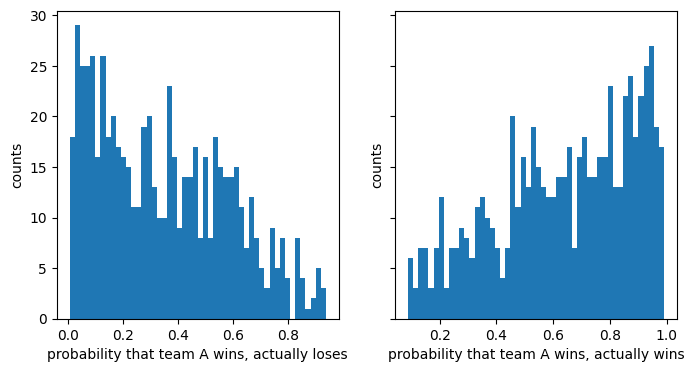

In [15]:
fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=True)

ax[0].hist(test_prob[Y_test == 0,1], bins=50)
ax[0].set_xlabel('probability that team A wins, actually loses')
ax[0].set_ylabel('counts')

ax[1].hist(test_prob[Y_test == 1,1], bins=50)
ax[1].set_xlabel('probability that team A wins, actually wins')
ax[1].set_ylabel('counts')